In [ ]:
# Датасет весом в 25 гигов не поместился ни в колабе, ни на компе
# здесь моя реализация этого задания, выполненная с помощь множества,
# скажем так, ухищрений. Прошу строго не судить)

In [24]:
# библиотека для работы с датасетами, позволяет скачать только часть Coco
# в колабе выкидывает с несовместимостями, все пришлось делать локально в новое
# виртуальное окружение
import fiftyone.zoo as foz

In [25]:
# загружаем чего не хватило
#!pip install tensorflow

In [26]:
#!pip install cython

In [27]:
# !cd /Users/Viktoryia/Documents/hw_4 && git clone https://github.com/cocodataset/cocoapi
# !cd /Users/Viktoryia/Documents/hw_4/cocoapi/PythonAPI && make

In [28]:
COCO_ROOT = '/Users/Viktoryia/Documents/hw_4'
import sys
import os
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf

In [29]:
# скачиваем данныеБ получилось гига на два

# train = foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     label_types=["segmentations"],
#     classes=["person"],
#     max_samples=1000)
# valid = foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     label_types=["segmentations"],
#     classes=["person"],
#     max_samples=200)

In [30]:
# предобрабатываем изображения
from tensorflow.keras.utils import load_img, img_to_array
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     image = image/255.0
     image = tf.image.resize(image, (224,224))
     return image 

images_train = []
train_path = []

for root, dir_, files in os.walk('/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/train/data'):
  for file in files:
    filepath = os.path.join(root, file)
    train_path.append(filepath)
sorted_pathces = sorted(train_path, key=lambda x :int(x.split('/')[-1].split('.')[0]))

for el in sorted_pathces:
    image = img_to_array(load_img(el))
    images_train.append(preprocess_image(image))    

In [31]:
sorted_pathces[:5]

['/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/train/data/000000000036.jpg',
 '/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/train/data/000000000049.jpg',
 '/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/train/data/000000000061.jpg',
 '/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/train/data/000000000074.jpg',
 '/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/train/data/000000000077.jpg']

In [32]:
images_validation =[]
valid_path = []

for root, dir_, files in os.walk('/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017/validation/data'):
  for file in files:
    filepath = os.path.join(root, file)
    valid_path.append(filepath)

sorted_pathces_valid = sorted(valid_path, key=lambda x :int(x.split('/')[-1].split('.')[0]))

for el in sorted_pathces_valid:
    image = img_to_array(load_img(el))
    images_validation.append(preprocess_image(image))    

In [33]:
len(images_validation), len(images_train)

(200, 1000)

In [35]:
# Здесь нужно было вытащить маски сегментации из json формата. 
# за основу брала вот это, но пришлось много дописывать: 
# https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047
dataDir='/Users/Viktoryia/Documents/hw_4/fiftyone/coco-2017'
dataType_train='train/data'
dataType_valid='validation/data'
annFile_t='{}/train/labels.json'.format(dataDir,dataType_train)
annFile_v='{}/validation/labels.json'.format(dataDir,dataType_valid)


cocot=COCO(annFile_t)
cocov=COCO(annFile_v)

catIDst = cocot.getCatIds()
catIDsv = cocov.getCatIds()
cats_t = cocot.loadCats(catIDst)
cats_v = cocov.loadCats(catIDsv)    

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [36]:
filterClasses = ['person']

catIds_train = cocot.getCatIds(catNms=filterClasses) 
catIds_valid = cocov.getCatIds(catNms=filterClasses) 

imgIds_train = cocot.getImgIds(catIds=catIds_train)
imgIds_valid = cocov.getImgIds(catIds=catIds_valid)
print("Number of images containing all the  classes:", len(imgIds_train))
print("Number of images containing all the  classes:", len(imgIds_valid))


img_t = cocot.loadImgs(imgIds_train)
img_v = cocov.loadImgs(imgIds_valid)


Number of images containing all the  classes: 1000
Number of images containing all the  classes: 200


In [37]:
img_t = sorted(img_t, key=lambda x: int(x['file_name'].split('.')[0]))
img_v  = sorted(img_v, key=lambda x: int(x['file_name'].split('.')[0]))

In [38]:
anns_t = []
anns_v = []
for el in img_t:
    annIds_t = cocot.getAnnIds(imgIds=el['id'], catIds=catIds_train, iscrowd=None)
    anns_train = cocot.loadAnns(annIds_t)
    anns_t.append(anns_train)
for el in img_v:
    annIds_v = cocov.getAnnIds(imgIds=el['id'], catIds=catIds_valid, iscrowd=None)
    anns_valid = cocov.loadAnns(annIds_v)
    anns_v.append(anns_valid)


Number of images containing all the  classes: 1000


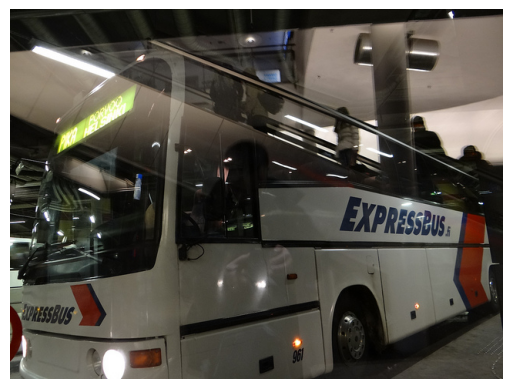

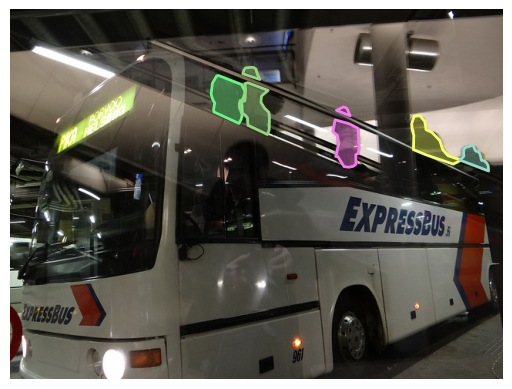

In [39]:
# Этот кусок для визуализации
catIds = cocot.getCatIds(catNms=filterClasses) 
imgIds = cocot.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))


img = cocot.loadImgs(imgIds[0])[0]
I = io.imread('{}//{}/{}'.format(dataDir,dataType_train,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()
plt.imshow(I)
plt.axis('off')
annIds = cocot.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = cocot.loadAnns(annIds)
cocot.showAnns(anns)

In [40]:
# маски пришлось генерировать вручную
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

m_train = []
m_valid = []
for ind, el in enumerate(anns_t):  
    mask = np.zeros((img_t[ind]['height'],img_t[ind]['width']))
    for i in range(len(el)):
        className = getClassName(el[i]['category_id'], cats_t)
        pixel_value = filterClasses.index(className)+1
        mask = np.maximum(cocot.annToMask(el[i])*pixel_value, mask)
    m_train.append(mask)
  

for ind, el in enumerate(anns_v):  
    mask = np.zeros((img_v[ind]['height'],img_v[ind]['width']))
    for i in range(len(el)):
        className = getClassName(el[i]['category_id'], cats_v)
        pixel_value = filterClasses.index(className)+1
        mask = np.maximum(cocov.annToMask(el[i])*pixel_value, mask)
    m_valid.append(mask)


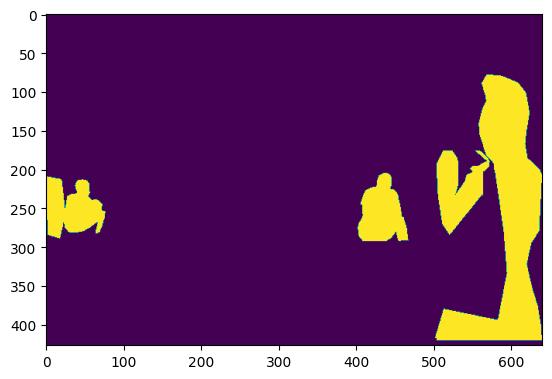

In [41]:
# результат маска
plt.imshow(m_valid[5])

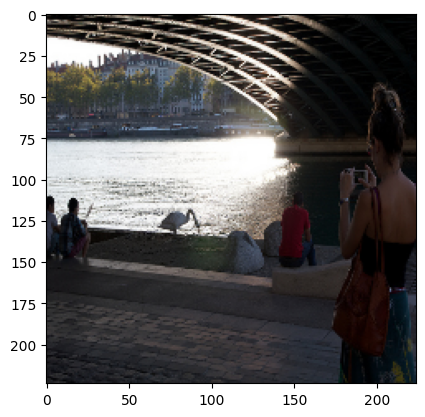

In [42]:
# картинка
plt.imshow(images_validation[5])

In [43]:
len(m_valid), len(images_validation)

(200, 200)

In [44]:
m_valid[0].shape, m_valid[8].shape

((426, 640), (315, 640))

In [45]:
type(m_valid[0]), type(images_validation[0])

(numpy.ndarray, tensorflow.python.framework.ops.EagerTensor)

In [46]:
# здесь подгоняем данные под модель: 
# переводим в тензор, изменяем размер
images_validation , images_train = tf.image.resize(tf.convert_to_tensor(images_validation),[256, 256]), tf.image.resize(tf.convert_to_tensor(images_train), [256, 256])

In [47]:
tensors_valid = [tf.image.resize(tf.expand_dims(tf.convert_to_tensor(i), -1 ), [256, 256]) for i in m_valid]
tensors_train = [tf.image.resize(tf.expand_dims(tf.convert_to_tensor(i), -1 ), [256, 256]) for i in m_train]
labels_valid , labels_train = tf.convert_to_tensor(tensors_valid), tf.convert_to_tensor(tensors_train)

In [48]:
images_validation[0].shape, tensors_valid[0].shape

(TensorShape([256, 256, 3]), TensorShape([256, 256, 1]))

In [49]:
len(images_train), len(tensors_train)

(1000, 1000)

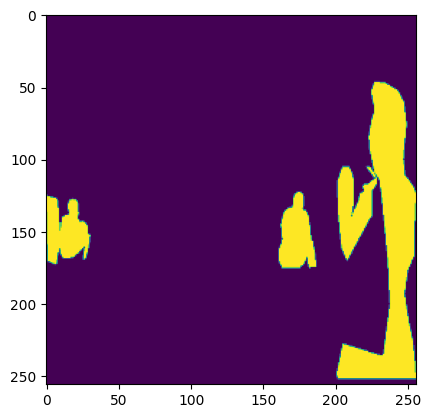

In [50]:
# проверим что получилось после изменения размерности
plt.imshow(tensors_valid[5])

In [51]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

Epoch 1/3
20/20 [==============================] - 5013s 247s/step - loss: 0.5171 - accuracy: 0.8258 - precision: 0.1876 - recall: 0.0138
Epoch 2/3
20/20 [==============================] - 4775s 239s/step - loss: 0.4317 - accuracy: 0.8335 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/3
20/20 [==============================] - 4698s 235s/step - loss: 0.4186 - accuracy: 0.8335 - precision: 0.0000e+00 - recall: 0.0000e+00


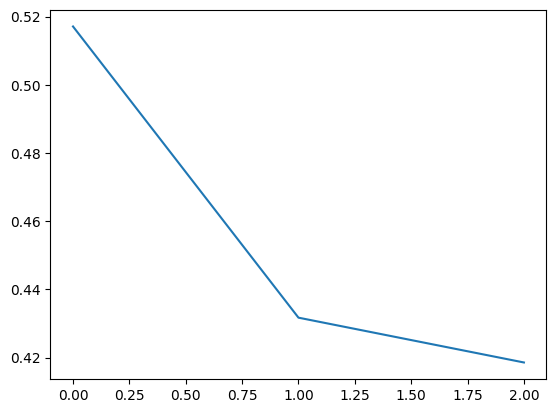

In [52]:
NUM_EPOCHS = 3
BATCH_SIZE = 50

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy', 'Precision', 'Recall'])

hist = model.fit(images_train, labels_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

In [53]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [54]:
predictions = model.predict(images_validation)

7/7 [==============================] - 242s 35s/step


In [74]:
# функция для визуализации
def show_result(index):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=1, ncols=3)
    ax1.set_title('Image')
    ax1.imshow(images_validation[index])

    ax2.set_title('Real mask')
    ax2.imshow(labels_valid[index])

    ax3.set_title('Predicted mask')
    ax3.imshow(predictions[index])


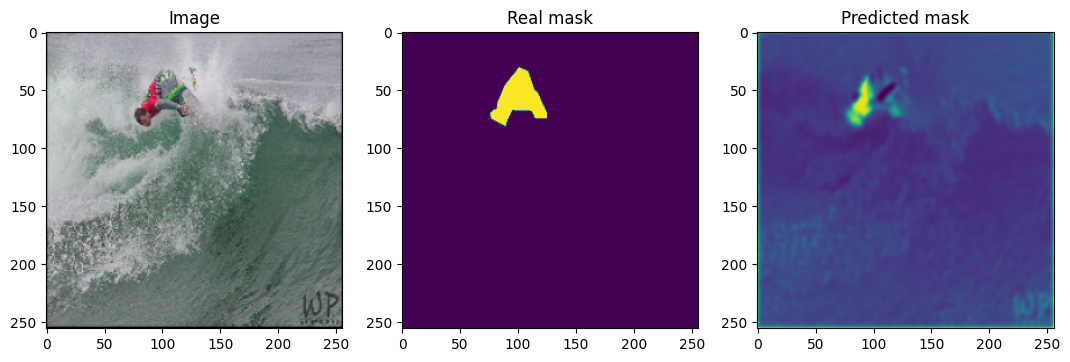

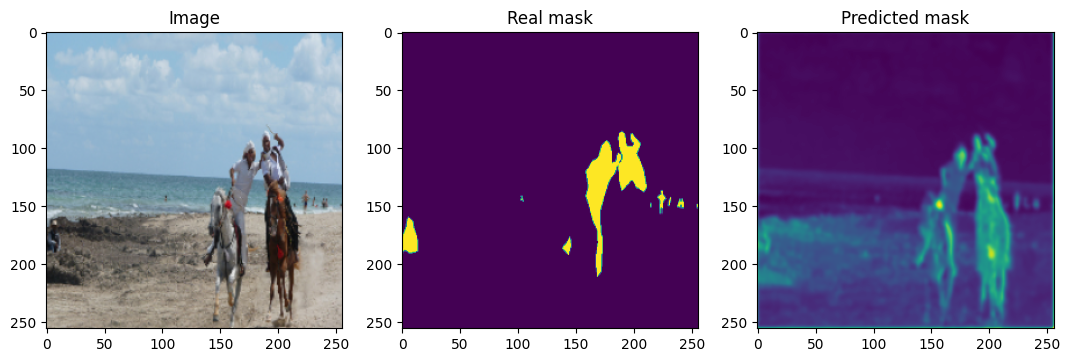

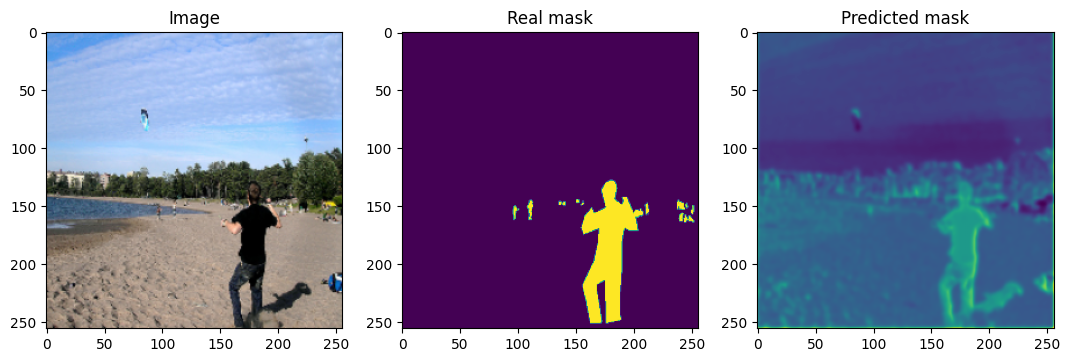

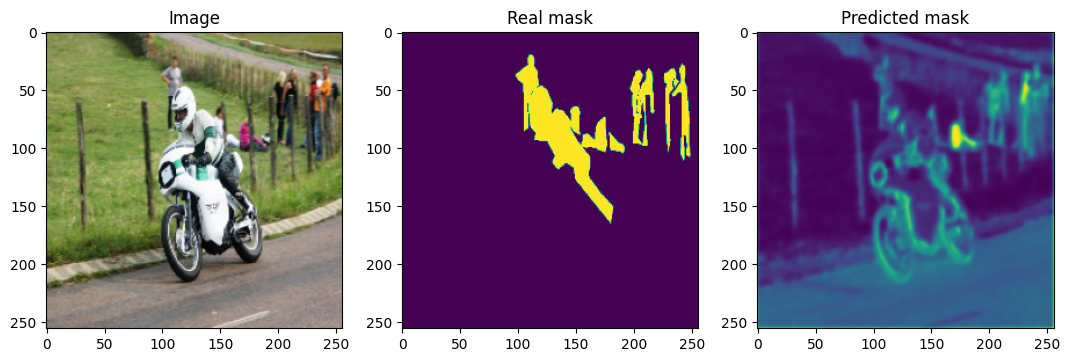

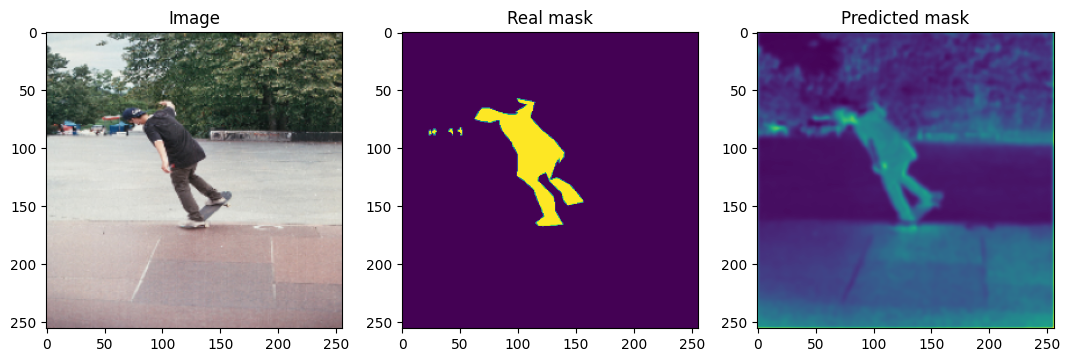

In [81]:
# Результат такой себе, но это локальная машина, три эпохи заняли 5 часов
for i in range(40, 45):
    show_result(i) 